In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotnine as p9

from sklearn import preprocessing
from brainsmash.mapgen.stats import spearmanr as bs_spearmanr
from statsmodels.stats.multitest import fdrcorrection

import pickle

In [2]:
# load expression
expr = pd.read_csv("../data/2.prodata/protomics_expr_processed.tsv", sep="\t", index_col=0)
expr_scale = pd.DataFrame(preprocessing.scale(expr, axis=1), index=expr.index, columns=expr.columns)

# load gradient
structral_gradient = pd.read_csv("../data/0.rawdata/from_cl/insula_gredient.tsv", sep="\t", index_col=0, header=None).values[:15].flatten()

# load cell type marker
celltype_marker = pd.read_csv("../data/0.rawdata/from_papers/celltypes_PSP.csv")

In [3]:
# prepare celltype marker list
total_genelist = pd.Series(expr_scale.index).str.split("|", expand=True)[1].unique()
celltype_marker_mmu = celltype_marker.loc[celltype_marker['gene'].isin(total_genelist), :]
celltype_class = celltype_marker_mmu['class'].unique()
celltype_marker_use = {celltype : set(celltype_marker_mmu.loc[celltype_marker_mmu['class']==celltype, "gene"].unique()) for celltype in celltype_class }
celltype_class

array(['Astro', 'Endo', 'Micro', 'Neuro-Ex', 'Neuro-In', 'Oligo', 'OPC'],
      dtype=object)

In [4]:
# clac posi/nega gene
gene_cor = bs_spearmanr(expr_scale.values, structral_gradient)
gene_cor = pd.DataFrame(gene_cor, columns=["spearman"], index=expr_scale.index)
gene_cor.sort_values(by="spearman", inplace=True)
posi_cor_gene = gene_cor.loc[gene_cor["spearman"]>0, :]
nega_cor_gene = gene_cor.loc[gene_cor["spearman"]<0, :]
posi_cor_gene.shape, nega_cor_gene.shape

((3183, 1), (2881, 1))

# 1. Validation

In [21]:
# validation
threshold_use = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
n_perm = 10000
ctd_validate_res = []
for threshold in threshold_use:
    posi_cor_thr = posi_cor_gene.quantile(1-threshold).values[0]
    nega_cor_thr = nega_cor_gene.quantile(threshold).values[0]

    # extract gene symbol
    posi_gene_symbol = pd.Series(posi_cor_gene.loc[posi_cor_gene['spearman']>=posi_cor_thr, ].index).str.split("|", expand=True)[1]
    nega_gene_symbol = pd.Series(nega_cor_gene.loc[nega_cor_gene['spearman']<=nega_cor_thr, ].index).str.split("|", expand=True)[1]
    print(posi_gene_symbol.shape, nega_gene_symbol.shape)

    # clac ratio
    ctd_posi = np.array([ posi_gene_symbol.isin(celltype_marker_use[celltype]).sum()/len(posi_gene_symbol) for celltype in celltype_class ])
    ctd_nega = np.array([ nega_gene_symbol.isin(celltype_marker_use[celltype]).sum()/len(nega_gene_symbol) for celltype in celltype_class ])

    # permutation
    ctd_posi_null, ctd_nega_null = np.zeros(shape=(n_perm, len(celltype_class))), np.zeros(shape=(n_perm, len(celltype_class)))
    for i, celltype in enumerate(celltype_class):
        for k in range(n_perm):
            perm_posi_gene_symbol = np.random.choice(total_genelist, size=len(posi_gene_symbol), replace=False )
            ctd_posi_null[k, i] = pd.Series(perm_posi_gene_symbol).isin(celltype_marker_use[celltype]).sum() / len(posi_gene_symbol)
            perm_nega_gene_symbol = np.random.choice(total_genelist, size=len(nega_gene_symbol), replace=False )
            ctd_nega_null[k, i] = pd.Series(perm_nega_gene_symbol).isin(celltype_marker_use[celltype]).sum() / len(nega_gene_symbol)
    
    # calc pval
    tmp_a = np.abs(ctd_posi_null - ctd_posi_null.mean(axis=0))
    tmp_b = np.abs(ctd_posi - ctd_posi_null.mean(axis=0))
    ctd_posi_pval = ((tmp_a>=tmp_b).sum(axis=0)+1)/(n_perm+1)
    ctd_posi_fdr = fdrcorrection(ctd_posi_pval, alpha=0.05, method="indep", is_sorted=False)[1]

    tmp_a = np.abs(ctd_nega_null - ctd_nega_null.mean(axis=0))
    tmp_b = np.abs(ctd_nega - ctd_nega_null.mean(axis=0))
    ctd_nega_pval = ((tmp_a>=tmp_b).sum(axis=0)+1)/(n_perm+1)
    ctd_nega_fdr = fdrcorrection(ctd_nega_pval, alpha=0.05, method="indep", is_sorted=False)[1]

    ctd_validate_res.append([ctd_posi, ctd_nega, ctd_posi_null, ctd_nega_null, ctd_posi_pval, ctd_nega_pval, ctd_posi_fdr, ctd_nega_fdr])

    #break

(163,) (146,)
(321,) (299,)
(641,) (585,)
(966,) (872,)
(1295,) (1158,)
(1595,) (1447,)
(1917,) (1729,)
(2246,) (2026,)
(2548,) (2317,)
(2884,) (2594,)
(3183,) (2881,)


In [24]:
#pickle.dump(ctd_validate_res, open("../res/4.ctd_res.pkl", "wb"))
ctd_validate_res = pickle.load(open("../res/4.ctd_res.pkl", "rb"))

In [82]:
posi_dat = pd.DataFrame([ ctd_validate_res[i][0] - ctd_validate_res[i][2].mean(axis=0) for i in range(len(threshold_use)) ], index=threshold_use, columns=celltype_class).melt(value_name="Ratio", var_name="Class")
posi_dat["FDR"] =  pd.DataFrame([ ctd_validate_res[i][6] for i in range(len(threshold_use)) ], index=threshold_use, columns=celltype_class).melt(value_name="FDR", var_name="Class")["FDR"]
posi_dat["Threshold"] = threshold_use * 7
posi_dat["Category"] = "Positive"


nega_dat = pd.DataFrame([ ctd_validate_res[i][1] - ctd_validate_res[i][3].mean(axis=0) for i in range(len(threshold_use)) ], index=threshold_use, columns=celltype_class).melt(value_name="Ratio", var_name="Class")
nega_dat["FDR"] =  pd.DataFrame([ ctd_validate_res[i][7] for i in range(len(threshold_use)) ], index=threshold_use, columns=celltype_class).melt(value_name="FDR", var_name="Class")["FDR"]
nega_dat["Threshold"] = threshold_use * 7
nega_dat["Category"] = "Negative"

validate_dat = pd.concat([posi_dat, nega_dat], axis=0)
validate_dat["Category"] = pd.Categorical(validate_dat["Category"], categories=["Positive", "Negative"])
validate_dat["Threshold"] = pd.Categorical(validate_dat["Threshold"], categories=threshold_use)
validate_dat_point = validate_dat.loc[validate_dat["FDR"]<0.05, :]

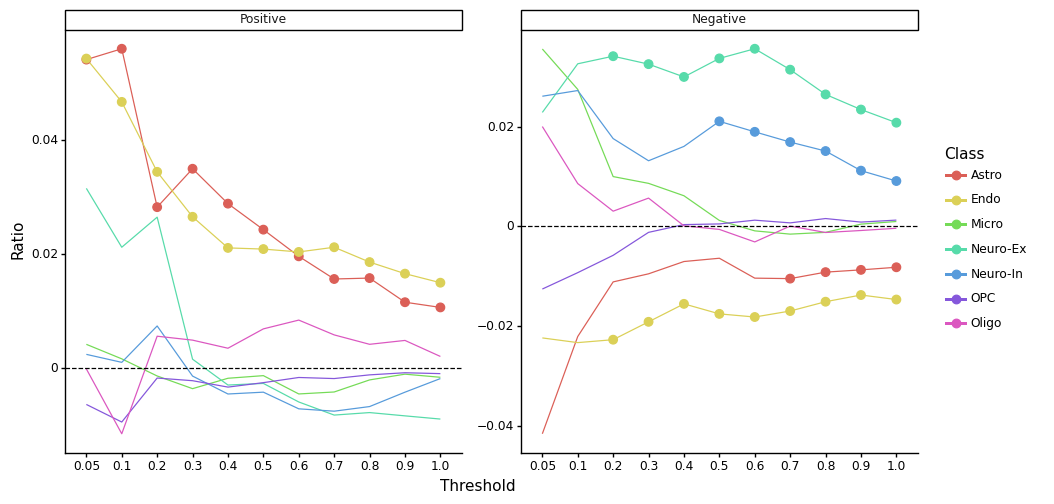

<ggplot: (8769185562859)>

In [94]:
validat_plot = (
    p9.ggplot(p9.aes(x="Threshold", y="Ratio", color="Class", group="Class"), validate_dat)
    + p9.geom_line()
    + p9.geom_point(p9.aes(x="Threshold",y="Ratio", color="Class"), validate_dat_point, size=3)
    + p9.geom_hline(yintercept=0, linetype="dashed")
    + p9.theme_classic()
    + p9.theme(figure_size=(11, 5.5),
               axis_text = p9.element_text(color="black"),
               subplots_adjust={"wspace":0.15})
    + p9.facet_wrap("~Category", ncol=2, scales="free_y")
)
p9.ggsave(validat_plot, "../res/ctd_validate.pdf", verbose=False)
validat_plot

# 2. Usage

In [97]:
# final usage

n_perm = 10000
threshold = 0.25
posi_cor_thr = posi_cor_gene.quantile(1-threshold).values[0]
nega_cor_thr = nega_cor_gene.quantile(threshold).values[0]

# extract gene symbol
posi_gene_symbol = pd.Series(posi_cor_gene.loc[posi_cor_gene['spearman']>=posi_cor_thr, ].index).str.split("|", expand=True)[1]
nega_gene_symbol = pd.Series(nega_cor_gene.loc[nega_cor_gene['spearman']<=nega_cor_thr, ].index).str.split("|", expand=True)[1]
print(posi_gene_symbol.shape, nega_gene_symbol.shape)

# clac ratio
ctd_posi = np.array([ posi_gene_symbol.isin(celltype_marker_use[celltype]).sum()/len(posi_gene_symbol) for celltype in celltype_class ])
ctd_nega = np.array([ nega_gene_symbol.isin(celltype_marker_use[celltype]).sum()/len(nega_gene_symbol) for celltype in celltype_class ])

# permutation
ctd_posi_null, ctd_nega_null = np.zeros(shape=(n_perm, len(celltype_class))), np.zeros(shape=(n_perm, len(celltype_class)))
for i, celltype in enumerate(celltype_class):
    for k in range(n_perm):
        perm_posi_gene_symbol = np.random.choice(total_genelist, size=len(posi_gene_symbol), replace=False )
        ctd_posi_null[k, i] = pd.Series(perm_posi_gene_symbol).isin(celltype_marker_use[celltype]).sum() / len(posi_gene_symbol)
        perm_nega_gene_symbol = np.random.choice(total_genelist, size=len(nega_gene_symbol), replace=False )
        ctd_nega_null[k, i] = pd.Series(perm_nega_gene_symbol).isin(celltype_marker_use[celltype]).sum() / len(nega_gene_symbol)

# calc pval
tmp_a = np.abs(ctd_posi_null - ctd_posi_null.mean(axis=0))
tmp_b = np.abs(ctd_posi - ctd_posi_null.mean(axis=0))
ctd_posi_pval = ((tmp_a>=tmp_b).sum(axis=0)+1)/(n_perm+1)
ctd_posi_fdr = fdrcorrection(ctd_posi_pval, alpha=0.05, method="indep", is_sorted=False)[1]

tmp_a = np.abs(ctd_nega_null - ctd_nega_null.mean(axis=0))
tmp_b = np.abs(ctd_nega - ctd_nega_null.mean(axis=0))
ctd_nega_pval = ((tmp_a>=tmp_b).sum(axis=0)+1)/(n_perm+1)
ctd_nega_fdr = fdrcorrection(ctd_nega_pval, alpha=0.05, method="indep", is_sorted=False)[1]

(808,) (732,)


In [99]:
#pickle.dump([ctd_posi, ctd_nega, ctd_posi_null, ctd_nega_null, ctd_posi_pval, ctd_nega_pval, ctd_posi_fdr, ctd_nega_fdr], open("../res/4.ctd_res_use.pkl", "wb"))
ctd_posi, ctd_nega, ctd_posi_null, ctd_nega_null, ctd_posi_pval, ctd_nega_pval, ctd_posi_fdr, ctd_nega_fdr = pickle.load(open("../res/4.ctd_res_use.pkl", "rb"))

In [166]:
ctd_posi, ctd_nega, ctd_posi_null, ctd_nega_null, ctd_posi_pval, ctd_nega_pval, ctd_posi_fdr, ctd_nega_fdr = pickle.load(open("../res/4.ctd_res_use.pkl", "rb"))

# dat for boxplot
ctd_posi_null = pd.DataFrame(ctd_posi_null, columns=celltype_class).melt(value_name="Ratio", var_name="Class")
ctd_posi_null["Category"] = "Positive"

ctd_nega_null = pd.DataFrame(ctd_nega_null, columns=celltype_class).melt(value_name="Ratio", var_name="Class")
ctd_nega_null["Category"] = "Negative"

boxplot_dat = pd.concat([ctd_posi_null, ctd_nega_null], axis=0)
boxplot_dat["Category"] = pd.Categorical(boxplot_dat["Category"], categories=["Positive", "Negative"])

# dat for scatter
ctd_posi = pd.DataFrame([ctd_posi, ctd_posi_fdr, celltype_class], index=["Ratio", "FDR", "Class"]).T
ctd_posi["Category"] = "Positive"

ctd_nega = pd.DataFrame([ctd_nega, ctd_nega_fdr, celltype_class], index=["Ratio", "FDR", "Class"]).T
ctd_nega["Category"] = "Negative"

scatter_dat = pd.concat([ctd_posi, ctd_nega], axis=0)
scatter_dat["Category"] = pd.Categorical(scatter_dat["Category"], categories=["Positive", "Negative"])
scatter_dat["Ratio"] = scatter_dat["Ratio"].astype(float)
scatter_dat["y"] = 0.22
scatter_dat["Label"] = [ f"* {fdr:.5f}" if fdr < 0.05 else f"{fdr:.5f}" for fdr in scatter_dat["FDR"] ]

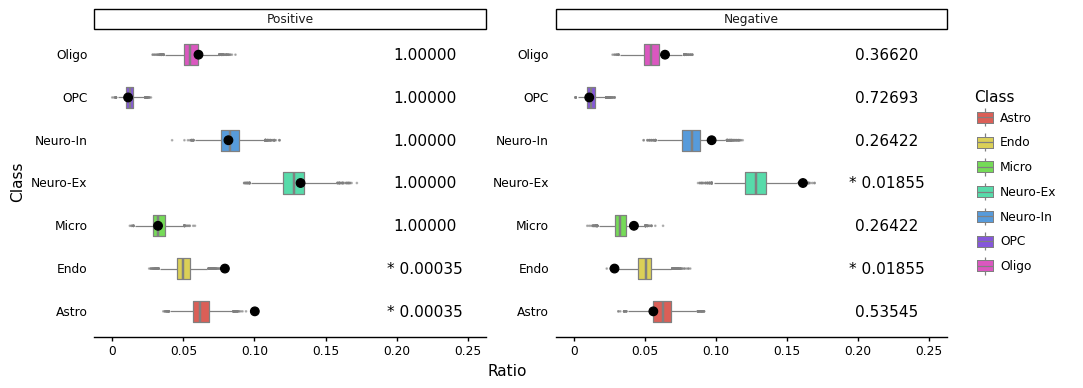

<ggplot: (8769185639352)>

In [181]:
ctd_plot = (
    p9.ggplot(p9.aes(x="Class", y="Ratio"), boxplot_dat)
    + p9.geom_boxplot(p9.aes(fill="Class"), color="grey", width=0.5, outlier_size=0.1, outlier_alpha=0.5)
    + p9.geom_point(p9.aes(x="Class", y="Ratio"), scatter_dat, color="black", size=3)
    + p9.geom_text(p9.aes(x="Class", y="y", label="Label"), scatter_dat,color="black")
    + p9.ylim(0, 0.25)
    + p9.theme_classic()
    + p9.theme(figure_size=(11, 4),
               axis_text = p9.element_text(color="black"),
               axis_line_y = p9.element_blank(),
               axis_ticks_major_y = p9.element_blank(),
               subplots_adjust={"wspace":0.18})
    + p9.coord_flip()
    + p9.facet_wrap("~Category", ncol=2, scales="free")
)
p9.ggsave(ctd_plot, "../res/ctd_use.pdf", verbose=False)
ctd_plot

In [184]:
posi_gene_symbol.to_csv("../res/4.posi_cor_gene.txt", sep="\t", index=False, header=False)
nega_gene_symbol.to_csv("../res/4.nega_cor_gene.txt", sep="\t", index=False, header=False)

# Functional annotation by toppGene

In [263]:
top_n = 10
# Positive correlation toppGene results
posi_anno = pd.read_csv("../res/4.posi_cor_gene_toppGene.txt", sep="\t")
posi_anno["Ratio"] = posi_anno["Hit Count in Query List"]/posi_anno["Hit Count in Genome"]

# GO
posi_anno_bp = posi_anno.loc[posi_anno["Category"]=="GO: Biological Process", :]
posi_anno_bp_dat = posi_anno_bp.iloc[:top_n, :].sort_values(by="Ratio", ascending=True)
posi_anno_bp_dat["Name"] = pd.Categorical(posi_anno_bp_dat["Name"], categories=posi_anno_bp_dat["Name"])
posi_anno_bp_dat["Type"] = "Positive"

# pathway
posi_anno_pathway = posi_anno.loc[posi_anno["Source"]=="BioSystems: KEGG", :]
posi_anno_pathway_dat = posi_anno_pathway.iloc[:top_n, :].sort_values(by="Ratio", ascending=True)
posi_anno_pathway_dat["Name"] = pd.Categorical(posi_anno_pathway_dat["Name"], categories=posi_anno_pathway_dat["Name"])
posi_anno_pathway_dat["Type"] = "Positive"

# Disease
posi_anno_disease = posi_anno.loc[posi_anno["Source"]=="DisGeNET BeFree", :]
posi_anno_disease_dat = posi_anno_disease.iloc[:top_n, :].sort_values(by="Ratio", ascending=True)
posi_anno_disease_dat["Name"] = pd.Categorical(posi_anno_disease_dat["Name"], categories=posi_anno_disease_dat["Name"])
posi_anno_disease_dat["Type"] = "Positive"


In [264]:
# Negative correlation toppGene results
nega_anno = pd.read_csv("../res/4.nega_cor_gene_toppGene.txt", sep="\t")
nega_anno["Ratio"] = nega_anno["Hit Count in Query List"]/nega_anno["Hit Count in Genome"]

# GO
nega_anno_bp = nega_anno.loc[nega_anno["Category"]=="GO: Biological Process", :]
nega_anno_bp_dat = nega_anno_bp.iloc[:top_n, :].sort_values(by="Ratio", ascending=True)
nega_anno_bp_dat["Name"] = pd.Categorical(nega_anno_bp_dat["Name"], categories=nega_anno_bp_dat["Name"])
nega_anno_bp_dat["Type"] = "Negative"

# pathway
nega_anno_pathway = nega_anno.loc[nega_anno["Source"]=="BioSystems: KEGG", :]
nega_anno_pathway_dat = nega_anno_pathway.iloc[:top_n, :].sort_values(by="Ratio", ascending=True)
nega_anno_pathway_dat["Name"] = pd.Categorical(nega_anno_pathway_dat["Name"], categories=nega_anno_pathway_dat["Name"])
nega_anno_pathway_dat["Type"] = "Negatve"

# Disease
nega_anno_disease = nega_anno.loc[nega_anno["Source"]=="DisGeNET BeFree", :]
nega_anno_disease_dat = nega_anno_disease.iloc[:top_n, :].sort_values(by="Ratio", ascending=True)
nega_anno_disease_dat["Name"] = pd.Categorical(nega_anno_disease_dat["Name"], categories=nega_anno_disease_dat["Name"])
nega_anno_disease_dat["Type"] = "Negative"

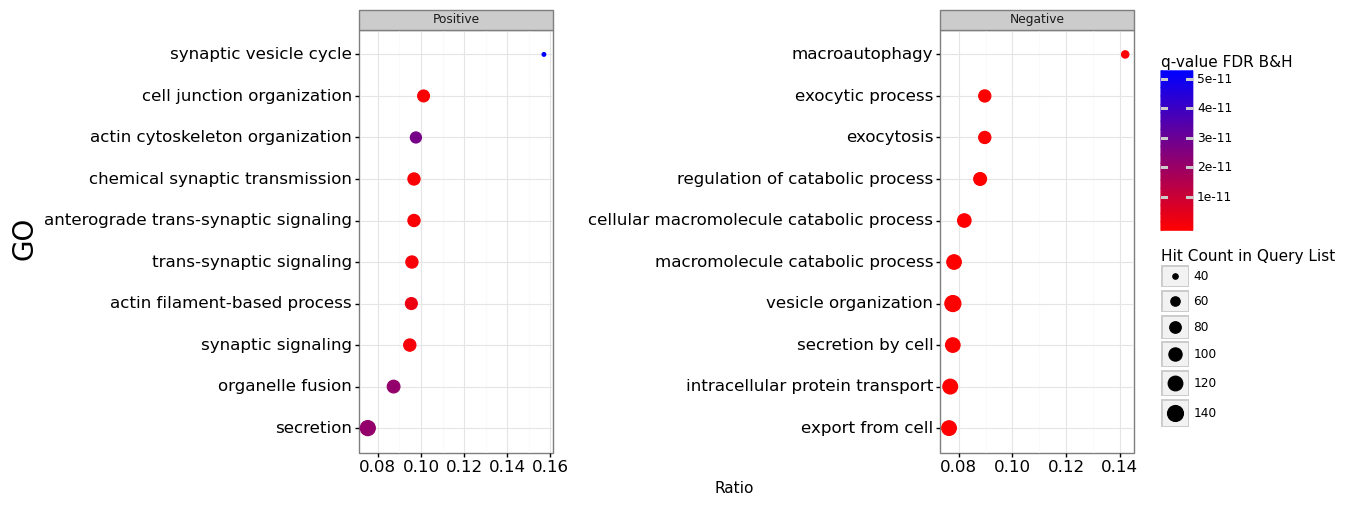

<ggplot: (8769185562236)>

In [277]:
go_dat = pd.concat([posi_anno_bp_dat, nega_anno_bp_dat], axis=0)
go_dat["Type"] = pd.Categorical(go_dat["Type"], categories=["Positive", "Negative"])
go_dat["Name"] = pd.Categorical(go_dat["Name"], categories=go_dat["Name"])

anno_bp_plot = (
    p9.ggplot(p9.aes(x="Name", y="Ratio", size="Hit Count in Query List", color="q-value FDR B&H"), go_dat)
    + p9.geom_point()
    + p9.coord_flip()
    + p9.scale_color_gradient(low = "red", high = "blue")
    + p9.xlab("GO")
    + p9.theme_bw()
    + p9.theme(axis_title_y = p9.element_text(size=20), 
               axis_text = p9.element_text(color="black", size=12),
               figure_size=(10, 5.5),
               subplots_adjust={'wspace': 2}
               )
    + p9.facet_wrap("~Type", ncol=2, scales="free")
)
p9.ggsave(anno_bp_plot, "../res/posi_cor_toppGene.pdf", verbose=False)
anno_bp_plot

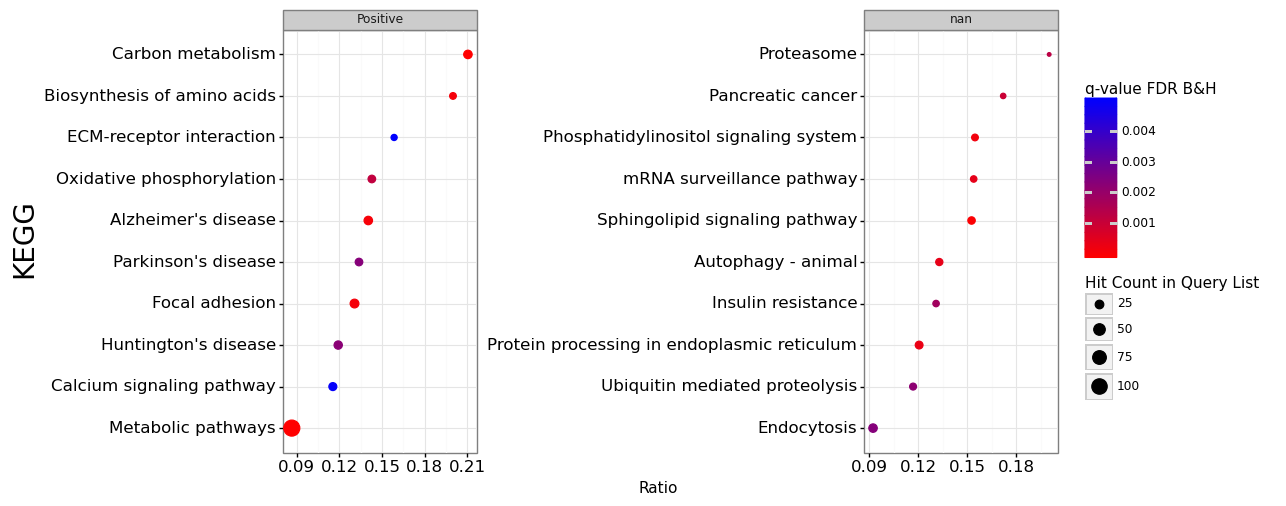

<ggplot: (8769185649421)>

In [274]:
pathway_dat = pd.concat([posi_anno_pathway_dat, nega_anno_pathway_dat], axis=0)
pathway_dat["Type"] = pd.Categorical(pathway_dat["Type"], categories=["Positive", "Negative"])
pathway_dat["Name"] = pd.Categorical(pathway_dat["Name"], categories=pathway_dat["Name"])

anno_pathway_plot = (
    p9.ggplot(p9.aes(x="Name", y="Ratio", size="Hit Count in Query List", color="q-value FDR B&H"), pathway_dat)
    + p9.geom_point()
    + p9.xlab("KEGG")
    + p9.coord_flip()
    + p9.scale_color_gradient(low = "red", high = "blue")
    + p9.theme_bw()
    + p9.theme(axis_title_y = p9.element_text(size=20), 
               axis_text = p9.element_text(color="black", size=12),
               figure_size=(10, 5.5),
               subplots_adjust={'wspace': 2}
               )
    + p9.facet_wrap("~Type", ncol=2, scales="free")
)
anno_pathway_plot

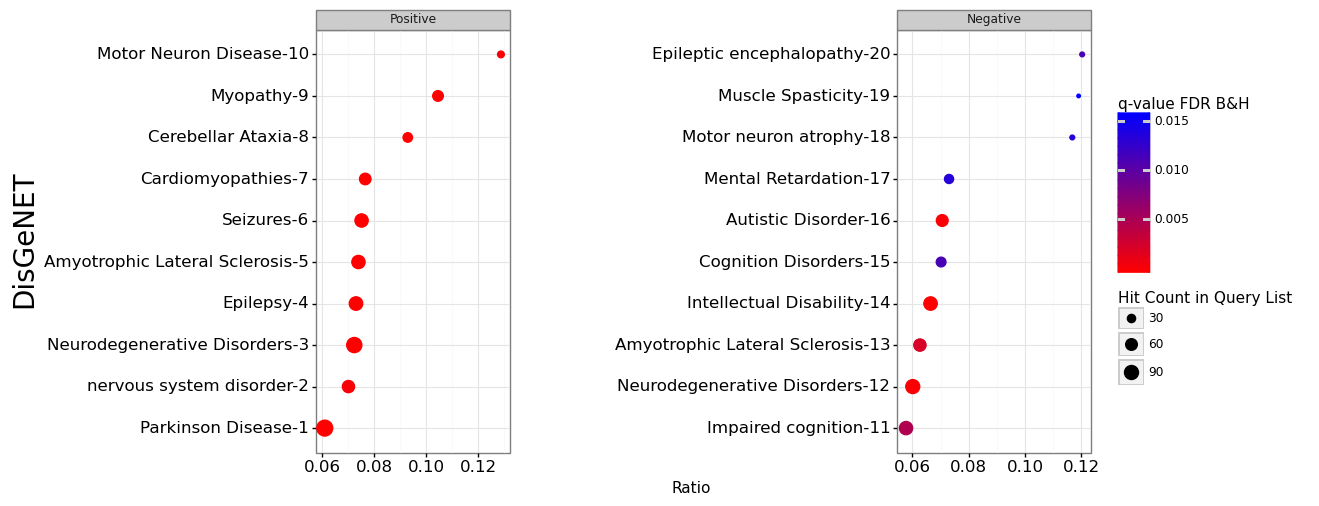

<ggplot: (8769185155856)>

In [275]:
disease_dat = pd.concat([posi_anno_disease_dat, nega_anno_disease_dat], axis=0)
disease_dat["Type"] = pd.Categorical(disease_dat["Type"], categories=["Positive", "Negative"])
disease_dat["Name"] = disease_dat["Name"] + [ "-"+str(i+1) for i in range(disease_dat.shape[0]) ]
disease_dat["Name"] = pd.Categorical(disease_dat["Name"], categories=disease_dat["Name"])

anno_disease_plot = (
    p9.ggplot(p9.aes(x="Name", y="Ratio", size="Hit Count in Query List", color="q-value FDR B&H"), disease_dat)
    + p9.geom_point()
    + p9.coord_flip()
    + p9.scale_color_gradient(low = "red", high = "blue")
    + p9.xlab("DisGeNET")
    + p9.theme_bw()
    + p9.theme(axis_title_y = p9.element_text(size=20), 
               axis_text = p9.element_text(color="black", size=12),
               figure_size=(10, 5.5),
               subplots_adjust={'wspace': 2}
               )
    + p9.facet_wrap("~Type", ncol=2, scales="free")
)
anno_disease_plot

# Functional annotation of diff protein by toppGene

In [279]:
top_n = 10
# cluster1tive correlation toppGene results
cluster1_anno = pd.read_csv("../res/2.diff_cluster1_toppGene.txt", sep="\t")
cluster1_anno["Ratio"] = cluster1_anno["Hit Count in Query List"]/cluster1_anno["Hit Count in Genome"]

# GO
cluster1_anno_bp = cluster1_anno.loc[cluster1_anno["Category"]=="GO: Biological Process", :]
cluster1_anno_bp_dat = cluster1_anno_bp.iloc[:top_n, :].sort_values(by="Ratio", ascending=True)
cluster1_anno_bp_dat["Name"] = pd.Categorical(cluster1_anno_bp_dat["Name"], categories=cluster1_anno_bp_dat["Name"])
cluster1_anno_bp_dat["Type"] = "Cluster1"

# pathway
cluster1_anno_pathway = cluster1_anno.loc[cluster1_anno["Source"]=="BioSystems: KEGG", :]
cluster1_anno_pathway_dat = cluster1_anno_pathway.iloc[:top_n, :].sort_values(by="Ratio", ascending=True)
cluster1_anno_pathway_dat["Name"] = pd.Categorical(cluster1_anno_pathway_dat["Name"], categories=cluster1_anno_pathway_dat["Name"])
cluster1_anno_pathway_dat["Type"] = "Cluster1"

# Disease
cluster1_anno_disease = cluster1_anno.loc[cluster1_anno["Source"]=="DisGeNET BeFree", :]
cluster1_anno_disease_dat = cluster1_anno_disease.iloc[:top_n, :].sort_values(by="Ratio", ascending=True)
cluster1_anno_disease_dat["Name"] = pd.Categorical(cluster1_anno_disease_dat["Name"], categories=cluster1_anno_disease_dat["Name"])
cluster1_anno_disease_dat["Type"] = "Cluster1"
cluster1_anno_bp_dat.shape, cluster1_anno_pathway_dat.shape, cluster1_anno_disease_dat.shape

((10, 13), (10, 13), (10, 13))

In [280]:
top_n = 10
# cluster2tive correlation toppGene results
cluster2_anno = pd.read_csv("../res/2.diff_cluster2_toppGene.txt", sep="\t")
cluster2_anno["Ratio"] = cluster2_anno["Hit Count in Query List"]/cluster2_anno["Hit Count in Genome"]

# GO
cluster2_anno_bp = cluster2_anno.loc[cluster2_anno["Category"]=="GO: Biological Process", :]
cluster2_anno_bp_dat = cluster2_anno_bp.iloc[:top_n, :].sort_values(by="Ratio", ascending=True)
cluster2_anno_bp_dat["Name"] = pd.Categorical(cluster2_anno_bp_dat["Name"], categories=cluster2_anno_bp_dat["Name"])
cluster2_anno_bp_dat["Type"] = "Cluster2"

# pathway
cluster2_anno_pathway = cluster2_anno.loc[cluster2_anno["Source"]=="BioSystems: KEGG", :]
cluster2_anno_pathway_dat = cluster2_anno_pathway.iloc[:top_n, :].sort_values(by="Ratio", ascending=True)
cluster2_anno_pathway_dat["Name"] = pd.Categorical(cluster2_anno_pathway_dat["Name"], categories=cluster2_anno_pathway_dat["Name"])
cluster2_anno_pathway_dat["Type"] = "Cluster2"

# Disease
cluster2_anno_disease = cluster2_anno.loc[cluster2_anno["Source"]=="DisGeNET BeFree", :]
cluster2_anno_disease_dat = cluster2_anno_disease.iloc[:top_n, :].sort_values(by="Ratio", ascending=True)
cluster2_anno_disease_dat["Name"] = pd.Categorical(cluster2_anno_disease_dat["Name"], categories=cluster2_anno_disease_dat["Name"])
cluster2_anno_disease_dat["Type"] = "Cluster2"

cluster2_anno_bp_dat.shape, cluster2_anno_pathway_dat.shape, cluster2_anno_disease_dat.shape

((10, 13), (4, 13), (0, 13))

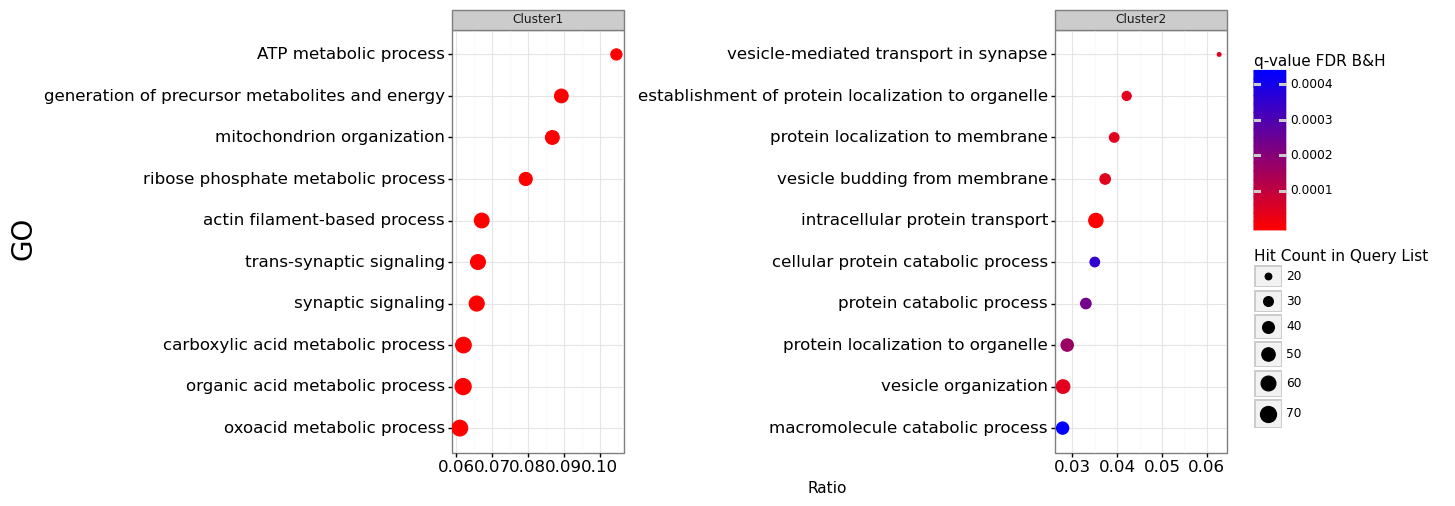

<ggplot: (8769184500249)>

In [283]:
cluster_go_dat = pd.concat([cluster1_anno_bp_dat, cluster2_anno_bp_dat], axis=0)
cluster_go_dat["Type"] = pd.Categorical(cluster_go_dat["Type"], categories=["Cluster1", "Cluster2"])
cluster_go_dat["Name"] = pd.Categorical(cluster_go_dat["Name"], categories=cluster_go_dat["Name"])

anno_bp_plot = (
    p9.ggplot(p9.aes(x="Name", y="Ratio", size="Hit Count in Query List", color="q-value FDR B&H"), cluster_go_dat)
    + p9.geom_point()
    + p9.coord_flip()
    + p9.scale_color_gradient(low = "red", high = "blue")
    + p9.xlab("GO")
    + p9.theme_bw()
    + p9.theme(axis_title_y = p9.element_text(size=20), 
               axis_text = p9.element_text(color="black", size=12),
               figure_size=(10, 5.5),
               subplots_adjust={'wspace': 2.5}
               )
    + p9.facet_wrap("~Type", ncol=2, scales="free")
)
#p9.ggsave(anno_bp_plot, "../res/posi_cor_toppGene.pdf", verbose=False)
anno_bp_plot